1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
import pandas as pd # standard naming convention
from datetime import datetime

In [2]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [3]:
file_name = "..\data\data_000637.txt"
N = 10000
data = pd.read_csv(file_name, nrows=N)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
9995,1,0,61,3869200267,696,11
9996,1,0,60,3869200267,701,5
9997,1,0,59,3869200267,707,23
9998,1,0,63,3869200267,706,15


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [4]:
def find_number_in_col(column_name):
    # Find the maximum value of the BX counter before it resets
    return data[column_name].max()

print(f"The number of BX in a ORBIT is: {find_number_in_col('BX_COUNTER')}")

The number of BX in a ORBIT is: 3563


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

*Hint:* introduce an offset to the absolute time such that the start of the data acquisition (i.e. the first entry) is zero.

In [5]:
def orbit_to_ns_converter(x):
    offset_hours = data.loc[x, ['ORBIT_CNT']].iloc[0]
    offset_minutes = data.loc[x, ['BX_COUNTER']].iloc[0] * 25
    offset_seconds = data.loc[x, ['TDC_MEAS']] * 25/30

    sec_in_min = find_number_in_col('TDC_MEAS') * 30
    min_in_h = find_number_in_col('BX_COUNTER') * 25

    amount_of_ns = offset_seconds.iloc[0] + sec_in_min * offset_minutes + sec_in_min * min_in_h * offset_hours

    return amount_of_ns

In [6]:
#me lo salvo in una variabile così non lo calcolo N volte
starting_offset = orbit_to_ns_converter(0)

new_data = data.assign(ABS_TIME = 0)

for x in range(N):
    new_data.loc[x, 'ABS_TIME'] = orbit_to_ns_converter(x) - starting_offset
    
new_data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,1,0,123,3869200167,2374,26,0
1,1,0,124,3869200167,2374,27,0
2,1,0,63,3869200167,2553,28,3893248
3,1,0,64,3869200167,2558,19,4002048
4,1,0,64,3869200167,2760,25,8395520
...,...,...,...,...,...,...,...
9995,1,0,61,3869200267,696,11,7713028480
9996,1,0,60,3869200267,701,5,7713137280
9997,1,0,59,3869200267,707,23,7713267776
9998,1,0,63,3869200267,706,15,7713246016


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [7]:
def ns_to_hms(ns):

  hours = ns // (3600 * 1e9)
  ns -= hours * 3600 * 1e9
  minutes = ns // (60 * 1e9)
  ns -= minutes * 60 * 1e9
  seconds = ns // 1e9
  
  return hours, minutes, seconds


In [8]:
# Calculate the duration
duration = new_data['ABS_TIME'].max() - new_data['ABS_TIME'].min()

hours, minutes, seconds = ns_to_hms(duration)

print(f"Duration: {hours} hours, {minutes} minutes, {seconds} seconds")

Duration: 0.0 hours, 0.0 minutes, 7.0 seconds


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [9]:
# Group by 'TDC_CHANNEL' and count the occurrences
grouped_data = new_data.groupby("TDC_CHANNEL").sum().sort_values(by='TDC_CHANNEL',ascending=False)
grouped_data.rename(columns={"HEAD": "TDC_COUNTS"}, inplace=True)
grouped_data = grouped_data.loc[:, ["TDC_COUNTS"]]
# Print the top 3 noisy channels and their counts
top_noisy_channels = grouped_data.head(3)

print("Top 3 Noisy Channels:")
print(top_noisy_channels)

Top 3 Noisy Channels:
             TDC_COUNTS
TDC_CHANNEL            
139                 860
128                  11
127                  10


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [10]:
# Filter out the rows with at least one hit
non_empty_orbits = data[data['ORBIT_CNT'] > 0]

# Count the number of unique orbits in the filtered dataset
num_non_empty_orbits = non_empty_orbits['ORBIT_CNT'].nunique()

print("Number of Non-Empty Orbits:", num_non_empty_orbits)

Number of Non-Empty Orbits: 101


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [11]:
def TdcCounter(x): 
    # Filter rows where TDC_CHANNEL is 139
    filtered_data = data[data['TDC_CHANNEL'] == x]

    # Count the number of unique orbits in the filtered dataset
    num_unique_orbits = filtered_data['ORBIT_CNT'].nunique()

    return num_unique_orbits

In [12]:
x = 139

print("Number of Unique Orbits with TDC_CHANNEL", x, TdcCounter(x))

Number of Unique Orbits with TDC_CHANNEL 139 101


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [13]:
grouped_data = new_data.groupby("TDC_CHANNEL").sum().sort_values(by='TDC_CHANNEL')
grouped_data.rename(columns={"HEAD": "TDC_COUNTS"}, inplace=True)

# Create Series for FPGA = 0
fpga0_series = grouped_data.loc[new_data["FPGA"] == 0, ["TDC_COUNTS"]].squeeze()

# Create Series for FPGA = 1
fpga1_series = grouped_data.loc[new_data["FPGA"] == 1, ["TDC_COUNTS"]].squeeze()

# Print the Series
print(fpga0_series)
print(fpga1_series)

TDC_CHANNEL
1      241
2      260
3      201
4      211
5      139
      ... 
125      2
126      1
127     10
128     11
139    860
Name: TDC_COUNTS, Length: 87, dtype: int64
TDC_CHANNEL
10     129
12     106
15      61
16      87
18      60
20      77
43      98
45      96
47     113
54     186
55       4
56     251
57     257
58     257
59     309
60     351
61     380
62     360
63     499
65      12
72      17
73      13
74      15
75       8
76       7
77       5
78       7
81      14
85      18
88      24
89      23
92      16
96      16
112     16
113     17
115     23
116     18
117     33
118     21
120     37
121     51
123    144
Name: TDC_COUNTS, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

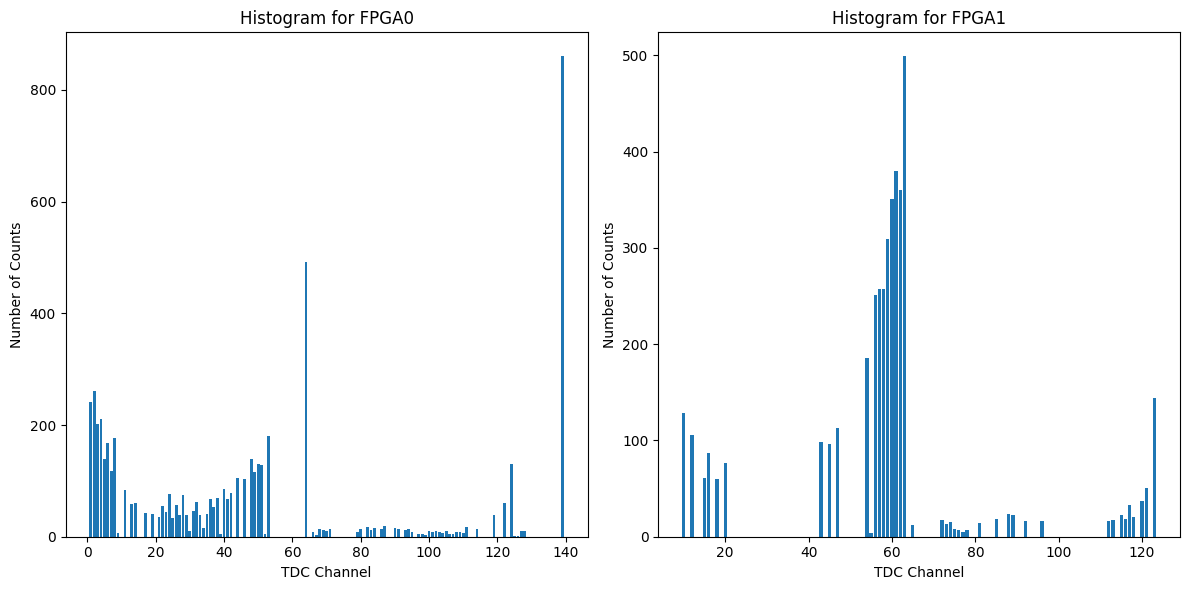

In [14]:
import matplotlib.pyplot as plt

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(fpga0_series.index, fpga0_series.values)
plt.title('Histogram for FPGA0')
plt.xlabel('TDC Channel')
plt.ylabel('Number of Counts')

plt.subplot(1, 2, 2)
plt.bar(fpga1_series.index, fpga1_series.values)
plt.title('Histogram for FPGA1')
plt.xlabel('TDC Channel')
plt.ylabel('Number of Counts')

plt.tight_layout()
plt.show()